# Import and inspect data

In [ ]:
import nltk
import requests
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# downloading 3 years data (2021-11-01 - 2018-11-01) from govt api 
TRAIN_URL = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-11-01&date_received_min=2018-11-01&field=all&format=csv&no_aggs=true&size=1171706&sort=created_date_desc"
r = requests.get(TRAIN_URL)
open('data.csv', 'wb').write(r.content)

885055048

In [ ]:
#loading data as data frame
df_orig = pd.read_csv('data.csv')
df = df_orig.copy()

**Inspecting Data:**

In [ ]:
# removing rows which have no narrative
df = df.dropna(subset=['Consumer complaint narrative'])

Picking "Product ,Consumer complaint narrative" for the model

In [ ]:
df = df[['Product', 'Consumer complaint narrative']]

**Renameing the colums:**

In [ ]:
df = df.rename(columns={"Product": "product",  "Consumer complaint narrative": "narrative"})

In [ ]:
# stopwords to be removed
sw_lst = stopwords.words('english') + list(string.punctuation) + ['--', 'xxxx',"''", '""', '...', '``']

Catogarising the data into 5 main departments:
1. Credit reporting
2. Debt collection
3. Mortgage and Loans
4. Retail Banking
5. Credit card

In [ ]:
df['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_reporting',
                       'Credit reporting': 'credit_reporting',
                       'Debt collection': 'debt_collection',
                       'Credit card or prepaid card': 'credit_card',
                       'Prepaid card': 'credit_card',
                       'Credit card': 'credit_card',
                       'Mortgage': 'mortgage',
                       'Checking or savings account': 'retail_banking',
                       'Money transfer, virtual currency, or money service': 'retail_banking',
                       'Other financial service':'retail_banking',
                       'Virtual currency':'retail_banking',
                       'Money transfers':'retail_banking',
                       'Bank account or service': 'retail_banking',
                       'Vehicle loan or lease': 'loans',
                       'Consumer Loan': 'loans',
                       'Payday loan': 'loans',
                       'Payday loan, title loan, or personal loan': 'loans',
                       'Student loan': 'loans'}, inplace=True)
df['product'].replace({'mortgage': 'mortgages_and_loans',
                       'loans': 'mortgages_and_loans'}, inplace=True)
df['product'].value_counts()

credit_reporting       251929
debt_collection         82338
mortgages_and_loans     63202
credit_card             45162
retail_banking          43134
Name: product, dtype: int64

In [ ]:
def process_txt(txt):
    tokens = nltk.word_tokenize(txt)
    sw_rmd = [token.lower() for token in tokens if token.lower() not in sw_lst]
    sw_punc_num_rmd = [w for w in sw_rmd if w.isalpha()]
    return sw_punc_num_rmd  

In [ ]:
def join_complaints(lst):
    words = ''
    for word in lst:
        words += word + ' '
    return words.strip()

# lemmatization of the words
lzm = WordNetLemmatizer()

def grouping(lst):
    lst = [i for i in lst if i is not np.nan]
    words = []
    for i, word in enumerate(lst):
        words.append(lzm.lemmatize(word))
    joined_complaint = join_complaints(words)
    return joined_complaint

In [ ]:
df = df.reset_index()
for i in tqdm(range(len(df))):
    comp_processed = process_txt(df['narrative'].loc[i])
    cmpl = grouping(comp_processed)
    df['narrative'][i] = cmpl
df.head()

  0%|          | 0/485765 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 485765/485765 [1:43:48<00:00, 77.99it/s]


,level_0,index,product,narrative
0,0,0,debt_collection,bill visit time visit receiving insurance addi...
1,1,6,credit_card,issue payment time got dinged even though requ...
2,2,8,credit_reporting,avictimof possibly even fraudulent misinformat...
3,3,10,credit_reporting,inquiry credit report fraudulent ssn credit re...
4,4,12,credit_reporting,may concern filing complaint experian wrote le...


In [ ]:
# Saving the processed data into csv file
df.to_csv('processed_train.csv')

Text(0.5, 1.0, 'Catogary distribution')

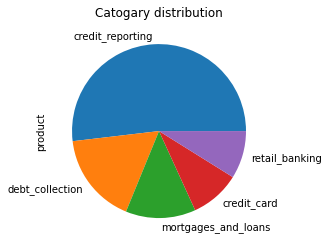

In [ ]:
catogary_count = df['product'].value_counts()
plot = catogary_count.plot(kind='pie')
plot.set_title("Catogary distribution")

From the above graph we can see the class imbalance as we can observe that we have more credit reporting and retail banking is the least. We must keep this mind and address this in building our model.

In [ ]:
# downloading data for testing the data. From 2022-11-01 to 2021-11-01 from same API
TEST_URL = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2022-11-01&date_received_min=2021-11-01&field=all&format=csv&no_aggs=true&size=1171706&sort=created_date_desc"
r = requests.get(TEST_URL)
open('data_test.csv', 'wb').write(r.content)

536241663

In [ ]:
df_test_orig = pd.read_csv('data_test.csv')
df_test = df_test_orig.copy()
df_test = df_test.dropna(subset=['Consumer complaint narrative'])
df_test = df_test[['Product', 'Consumer complaint narrative']]
df_test = df_test.reset_index()
df_test = df_test.rename(columns={"Product": "product",  "Consumer complaint narrative": "narrative"})

In [ ]:
df_test['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_reporting',
                       'Credit reporting': 'credit_reporting',
                       'Debt collection': 'debt_collection',
                       'Credit card or prepaid card': 'credit_card',
                       'Prepaid card': 'credit_card',
                       'Credit card': 'credit_card',
                       'Mortgage': 'mortgage',
                       'Checking or savings account': 'retail_banking',
                       'Money transfer, virtual currency, or money service': 'retail_banking',
                       'Other financial service':'retail_banking',
                       'Virtual currency':'retail_banking',
                       'Money transfers':'retail_banking',
                       'Bank account or service': 'retail_banking',
                       'Vehicle loan or lease': 'loans',
                       'Consumer Loan': 'loans',
                       'Payday loan': 'loans',
                       'Payday loan, title loan, or personal loan': 'loans',
                       'Student loan': 'loans'}, inplace=True)
df_test['product'].replace({'mortgage': 'mortgages_and_loans',
                       'loans': 'mortgages_and_loans'}, inplace=True)
df_test['product'].value_counts()

credit_reporting       196098
debt_collection         30894
retail_banking          23161
mortgages_and_loans     22741
credit_card             19440
Name: product, dtype: int64

In [ ]:
# Saving the processed data into csv file
for i in tqdm(range(len(df_test))):
    processed_narr = process_narrative(df_test['narrative'].loc[i])
    narr = make_lemma_and_concat(processed_narr)
    df_test['narrative'].loc[i] = narr

100%|██████████| 292334/292334 [44:43<00:00, 108.93it/s]
